In [1]:
import matplotlib.pyplot as plt
import torch
import time

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from tqdm import trange

In [2]:
# class Dataset(torch.utils.data.Dataset):
#     """
#     Class overloading the torch.utils.data.Dataset class to 
#     create a custom dataset object
#     """
# 
#     def __init__ (self, x, y):
#         self.x = x
#         self.y = y
#         # type casting to avoid errors and warnings with the network
#         self.x = self.x.float()
#         self.y = self.y.long()
# 
#     def __len__ (self): 
#         return(len(self.y))
# 
#     def __getitem__ (self, idx):
#        return self.x[idx], self.y[idx]

In [3]:
class Dataset(torch.utils.data.Dataset):
    """
    overload dataset
    """

    def __init__ (self, images, labels):
        self.images = images
        self.labels = labels
        self.images = self.images.float()
        self.labels = self.labels.long()

    def __len__ (self): 
        return(len(self.images))

    def __getitem__ (self, idx):
        return self.images[idx], self.labels[idx]
    
    def shuffle(self):
        idx = torch.randperm(self.__len__())
        self.images = self.images[idx]
        self.labels = self.labels[idx]
    
    def train_val_test_split(self, train_percentage=0.7, val_percentage=0.15, test_percentage=0.15):
        # split the data
        self.shuffle()
        train_data = self[:int(train_percentage*self.__len__())]
        val_data = self[int(train_percentage*self.__len__()):int((train_percentage+val_percentage)*self.__len__())]
        test_data = self[int((train_percentage+val_percentage)*self.__len__()):]
        return Dataset(train_data[0], train_data[1]), Dataset(val_data[0], val_data[1]), Dataset(test_data[0], test_data[1])

In [4]:
# load the data
data = torch.load('data/leukemia/leukemia_dataset.pt')

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
class BrainClassifier(nn.Module):
    def __init__(self):
        super(BrainClassifier, self).__init__()

        # Define layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)  # RGB images
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)  # greyscale images
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        # Calculate the input size of the fully connected layer according to the output of the conv layers
        fc_input_size = 64 * 64 * 64
        self.fc = nn.Linear(fc_input_size, 3) # 3 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.fc(x)
        # by default CrossEntropyLoss compute the softmax itself.
        # if leaved uncommented somewhy (????) the model does not learn 
        # remeber to put by hand when you do predictions
        # x = F.softmax(x, dim=1)  
        return x


In [7]:
class LeukemiaClassifier(nn.Module):
    def __init__(self):
        super(LeukemiaClassifier, self).__init__()

        # Define layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)  # RGB images
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        # Calculate the input size of the fully connected layer according to the output of the conv layers
        fc_input_size = 64 * 28 * 28  # Adjusted for 224x224 input size
        self.fc = nn.Linear(fc_input_size, 4) # Adjusted for 4 classes

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.fc(x)
        return x

In [8]:
class minst_classifier(nn.Module):
    def __init__(self):
        super(minst_classifier, self).__init__()

        # Define layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the flattened size
        self.flatten_size = 64 * 3 * 3  # Adjusted from 4*4 to 3*3
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(self.flatten_size, 10)  # Adjust accordingly

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = self.pool2(x)

        x = F.relu(self.conv3(x))
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc(x)
        x = F.softmax(x, dim=1)

        return x

In [9]:
# Define the training loop
def train(model, train_data, val_data, epochs=10, lr=0.001):
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Store the losses
    train_losses = []
    val_losses = []

    # Move model to the appropriate device
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in trange(epochs):
        # Set the model to training mode
        model.train()

        # Iterate over the training data
        for i, (img, label) in enumerate(train_data):
            # Move data to the appropriate device
            img, label = img.to(device), label.to(device)

            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            y_pred = model(img)
            # Compute the loss
            loss = criterion(y_pred, label.long())
            # Backward pass
            loss.backward()
            # Update the weights
            optimizer.step()
            # Store the loss
            train_losses.append(loss.item())
            # Print the loss
            # if i % 10 == 0:
            #     print(f'Epoch {epoch}, Iteration {i}, Loss {loss.item()}')

        # Set the model to evaluation mode
        model.eval()
        # Compute the validation loss
        val_loss = 0
        with torch.no_grad():
            for img, label in val_data:
                # Move data to the appropriate device
                img, label = img.to(device), label.to(device)
                y_pred = model(img)
                loss = criterion(y_pred, label.long())
                val_loss += loss.item()

        val_losses.append(val_loss / len(val_data))

        if epoch % 5 == 0:
            print(f'Epoch {epoch}, Validation Loss {val_loss / len(val_data)}')

    return train_losses, val_losses

In [10]:
#  set the seed before the split
torch.manual_seed(42)
data_train, data_val, data_test = data.train_val_test_split()

# Create the DataLoaders
train_loader = DataLoader(data_train, batch_size=32, shuffle=True)
val_loader = DataLoader(data_val, batch_size=32, shuffle=False)
test_loader = DataLoader(data_test, batch_size=data_test.__len__(), shuffle=False)


In [11]:
# Test with the NIST dataset

# Define the transformations
# transform = transforms.Compose([
#     transforms.ToTensor(),  # Converts to float32 and scales to [0, 1]
#     transforms.Normalize((0.5,), (0.5,))  # Normalize with mean 0.5 and std 0.5 (example values, adjust if needed)
# ])

# Load the dataset
# train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# val_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# # Create data loaders

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# model = minst_classifier()


In [12]:
# Example instantiation and training
# model = BrainClassifier()
model = LeukemiaClassifier()
tstart = time.time()

train_losses, val_losses = train(model, train_loader, val_loader, epochs=75, lr=0.001)

tend = time.time()
print("Time elapsed: ", tend-tstart)

  0%|                                                                              | 0/75 [00:00<?, ?it/s]/orfeo/cephfs/home/dssc/ipasia00/deepenv/lib64/python3.9/site-packages/torch/nn/modules/conv.py:456: UserWarning: Attempt to open cnn_infer failed: handle=0 error: libcudnn_cnn_infer.so.8: cannot open shared object file: No such file or directory (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:81.)
  return F.conv2d(input, weight, bias, self.stride,
  1%|▉                                                                     | 1/75 [00:01<01:48,  1.46s/it]

Epoch 0, Validation Loss 0.8420658558607101


  8%|█████▌                                                                | 6/75 [00:07<01:19,  1.15s/it]

Epoch 5, Validation Loss 0.5224240701645613


 15%|██████████                                                           | 11/75 [00:12<01:11,  1.11s/it]

Epoch 10, Validation Loss 0.6180852921679616


 21%|██████████████▋                                                      | 16/75 [00:18<01:04,  1.10s/it]

Epoch 15, Validation Loss 1.0239964425563812


 28%|███████████████████▎                                                 | 21/75 [00:23<00:59,  1.10s/it]

Epoch 20, Validation Loss 1.389097482257057


 35%|███████████████████████▉                                             | 26/75 [00:29<00:54,  1.12s/it]

Epoch 25, Validation Loss 1.3769159922376275


 41%|████████████████████████████▌                                        | 31/75 [00:34<00:49,  1.12s/it]

Epoch 30, Validation Loss 1.5678843772038817


 48%|█████████████████████████████████                                    | 36/75 [00:40<00:44,  1.14s/it]

Epoch 35, Validation Loss 1.762133002281189


 55%|█████████████████████████████████████▋                               | 41/75 [00:46<00:38,  1.13s/it]

Epoch 40, Validation Loss 1.8256390243768692


 61%|██████████████████████████████████████████▎                          | 46/75 [00:51<00:32,  1.13s/it]

Epoch 45, Validation Loss 1.9527046009898186


 68%|██████████████████████████████████████████████▉                      | 51/75 [00:57<00:27,  1.13s/it]

Epoch 50, Validation Loss 2.00428512878716


 75%|███████████████████████████████████████████████████▌                 | 56/75 [01:02<00:20,  1.10s/it]

Epoch 55, Validation Loss 2.0520190875977278


 81%|████████████████████████████████████████████████████████             | 61/75 [01:08<00:15,  1.13s/it]

Epoch 60, Validation Loss 2.125937173143029


 88%|████████████████████████████████████████████████████████████▋        | 66/75 [01:14<00:10,  1.14s/it]

Epoch 65, Validation Loss 2.174422664567828


 95%|█████████████████████████████████████████████████████████████████▎   | 71/75 [01:19<00:04,  1.13s/it]

Epoch 70, Validation Loss 2.229642616584897


100%|█████████████████████████████████████████████████████████████████████| 75/75 [01:24<00:00,  1.13s/it]

Time elapsed:  84.63272047042847


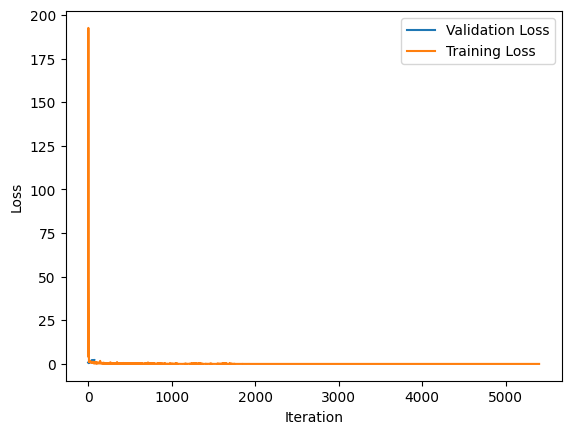

In [13]:
# plot the losses
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
# Save the model weights
torch.save(model.state_dict(), 'Leukemia_weights.pth')

In [15]:
x, y = next(iter(test_loader))

In [16]:
model.eval()
y_pred = model(x.to(device)).argmax(1)

In [17]:
y # vere label

tensor([3, 1, 1, 0, 3, 3, 2, 2, 1, 2, 1, 3, 0, 2, 0, 3, 2, 2, 3, 1, 1, 0, 1, 3,
        3, 3, 3, 2, 2, 2, 2, 2, 0, 0, 1, 1, 2, 3, 3, 3, 2, 3, 1, 1, 0, 1, 0, 1,
        1, 3, 0, 0, 1, 1, 2, 3, 2, 3, 0, 2, 0, 3, 2, 0, 0, 3, 2, 2, 2, 3, 1, 2,
        1, 3, 3, 3, 2, 1, 2, 1, 0, 1, 0, 1, 2, 2, 3, 0, 3, 3, 2, 2, 0, 3, 3, 3,
        2, 1, 2, 0, 0, 1, 2, 0, 0, 1, 1, 1, 2, 2, 2, 1, 0, 1, 3, 3, 1, 3, 1, 3,
        2, 0, 2, 2, 1, 0, 3, 1, 2, 1, 3, 2, 0, 2, 2, 3, 1, 3, 0, 1, 2, 2, 2, 3,
        3, 1, 2, 3, 2, 1, 2, 1, 3, 3, 1, 3, 1, 2, 1, 2, 3, 3, 3, 0, 2, 1, 1, 2,
        2, 1, 2, 3, 2, 0, 3, 2, 2, 3, 0, 0, 0, 1, 2, 2, 1, 1, 3, 2, 0, 1, 1, 3,
        0, 2, 1, 3, 1, 0, 2, 0, 3, 2, 1, 1, 3, 3, 2, 0, 2, 1, 0, 3, 2, 3, 2, 3,
        3, 1, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 0, 2, 1, 3, 1, 2, 3, 1, 0, 3, 0, 1,
        1, 0, 2, 2, 2, 1, 1, 2, 2, 3, 3, 1, 1, 2, 0, 2, 2, 1, 0, 1, 1, 2, 0, 2,
        3, 3, 0, 3, 1, 2, 3, 1, 0, 1, 3, 1, 0, 2, 1, 3, 0, 1, 1, 1, 3, 0, 0, 2,
        2, 2, 2, 0, 2, 3, 3, 2, 3, 1, 0,

In [18]:
y_pred

tensor([3, 1, 1, 0, 3, 3, 2, 2, 0, 1, 1, 3, 0, 2, 1, 3, 2, 2, 3, 1, 1, 0, 2, 3,
        3, 3, 3, 2, 2, 2, 2, 2, 0, 2, 1, 1, 2, 3, 3, 3, 2, 3, 1, 1, 0, 0, 1, 0,
        1, 3, 0, 0, 1, 1, 2, 3, 2, 3, 0, 2, 0, 3, 2, 0, 2, 3, 2, 1, 2, 3, 2, 2,
        1, 3, 3, 3, 2, 1, 2, 1, 2, 1, 0, 1, 2, 2, 3, 0, 3, 3, 2, 2, 0, 3, 3, 3,
        2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 1, 2, 1, 2, 1, 1, 1, 1, 3, 3, 1, 3, 1, 3,
        2, 1, 2, 2, 0, 1, 3, 1, 2, 1, 3, 1, 0, 2, 1, 3, 1, 3, 2, 1, 2, 2, 2, 3,
        3, 1, 2, 3, 2, 0, 2, 0, 3, 3, 1, 3, 1, 2, 1, 2, 3, 3, 3, 1, 2, 1, 0, 2,
        2, 1, 2, 3, 2, 0, 3, 2, 2, 3, 1, 0, 1, 2, 2, 2, 1, 1, 3, 2, 0, 1, 1, 3,
        0, 2, 0, 3, 0, 0, 2, 0, 3, 2, 1, 2, 3, 3, 1, 1, 2, 1, 1, 3, 2, 3, 0, 3,
        3, 1, 0, 0, 1, 0, 2, 1, 2, 2, 2, 2, 2, 2, 1, 3, 1, 2, 3, 1, 1, 3, 0, 2,
        1, 0, 2, 2, 2, 1, 2, 2, 2, 3, 3, 1, 1, 2, 2, 2, 2, 1, 0, 1, 1, 2, 1, 2,
        3, 3, 0, 3, 1, 1, 3, 1, 1, 1, 3, 1, 2, 2, 2, 3, 0, 0, 1, 1, 3, 0, 0, 2,
        2, 2, 1, 1, 2, 3, 3, 2, 3, 1, 0,

In [19]:
# compute the accuracy
correct = 0
total = 0
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        y_pred = model(img)
        correct += (y_pred.argmax(1) == label).sum().item()
        total += label.size(0)

print(f'Accuracy: {correct / total}')

Accuracy: 0.8282208588957055


In [20]:
model2 = LeukemiaClassifier()
model2.eval()
x, y = next(iter(test_loader))
y_pred = model(x.to(device)).argmax(1)

correct = 0
total = 0
with torch.no_grad():
    for img, label in test_loader:
        img, label = img.to(device), label.to(device)
        y_pred = model(img)
        correct += (y_pred.argmax(1) == label).sum().item()
        total += label.size(0)

print(f'Accuracy: {correct / total}')

Accuracy: 0.8282208588957055
